In [1]:
# import tsfresh

In [2]:
import numpy as np
import shap
n_features = 'all'
# data_file_name = 'data_for_training_tsfeatures_models'
data_file_name = 'data_for_traj_trcovw_6_model'

endpt = 17
eval_times = np.r_[np.arange(1, endpt+1, 1)]
training_id_file_name = 'all_training_set_ID_2'
validation_id_file_name = 'all_validation_set_ID_2'
testing_id_file_name = 'all_testing_set_ID_2'
#work_dir = '/home/idies/workspace/Storage/hnguye78/persistent/CARDIA_longi_project/'
work_dir = 'U:/Hieu/CARDIA_longi_project/'

In [3]:
# %pip install plotly
# %pip install tensorflow
# %pip install lifelines

#!y | pip uninstall statsmodels 
# %pip install statsmodels==0.11.0

# %pip install keras

In [4]:
import pkg_resources
#pkg_resources.require("scikit-learn==1.0.2")
import sklearn

import sksurv

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from numpy.random import seed

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

In [5]:
load_dir = work_dir+ '/csv_files'

# load data:
data_full = pd.read_csv(load_dir+'/'+data_file_name+'.csv')
data_full = data_full.select_dtypes(include =[np.number])



In [6]:
# load training id:
loaddir = work_dir+ '/csv_files'
trainingid_all = pd.read_csv(loaddir+'/'+training_id_file_name+'.csv')
validationid_all = pd.read_csv(loaddir+'/'+validation_id_file_name+'.csv')
testingid_all = pd.read_csv(loaddir+'/'+testing_id_file_name+'.csv')


## no need to standardize feature space since RSF can handle it, then merge back to label space:
feature_space = data_full.drop(['ID','event','time'], axis = 1)
feature_name_list = feature_space.columns.values


In [7]:
data_full

ID  event       time  RACEBLACK  MALE  ASMA_cluster  \
0     100033323702      0  17.134155          0     1             3   
1     100056526386      0  17.142368          1     1             2   
2     100061300991      0  17.427105          1     1             2   
3     100080112533      0  17.057495          1     1             2   
4     100101126081      0  17.424367          1     0             2   
...            ...    ...        ...        ...   ...           ...   
3534  416752023336      0  16.704312          1     1             1   
3535  416761219907      0  16.674196          0     0             2   
3536  416783315386      0  16.690623          0     0             2   
3537  416796224310      0  16.761807          1     0             3   
3538  416817227898      0  16.770021          1     1             2   

      BEER_cluster  CANCR_cluster  CGTDY_cluster  DIAB_cluster  ...  \
0                1              1              2             2  ...   
1                1              1              2             2  ...   
2                2              1              1             2  ...   
3                1              1              2             2  ...   
4                2              1              1             2  ...   
...            ...            ...            ...           ...  ...   
3534             2              1              2             2  ...   
3535             2              1              2             2  ...   
3536             2              1              1             2  ...   
3537             2              1              2             2  ...   
3538             2              1              1             2  ...   

      PSTYR_cluster  PULSE_cluster  WGT_cluster  WST_cluster  DBP_cluster  \
0                 3              3            3            1            2   
1                 3              2            3            2            1   
2                 1              3            3            1            2   
3                 2              2            1            2            2   
4                 3              3            1            2            2   
...             ...            ...          ...          ...          ...   
3534              3              3            1            1            2   
3535              2              2            3            1            2   
3536              2              2            3            1            2   
3537              1              2            2            3            2   
3538              1              2            3            2            1   

      SBP_cluster  AGE_Y15  CHNOW_cluster  PATCK_cluster  LIVER_cluster  
0               1       37              0              0              0  
1               2       43              0              0              0  
2               3       35              0              0              0  
3               2       35              0              0              0  
4               2       43              0              0              0  
...           ...      ...            ...            ...            ...  
3534            2       41              0              0              0  
3535            3       45              0              1              0  
3536            1       42              0              0              0  
3537            3       42              0              1              0  
3538            1       37              0              0              0  

[3539 rows x 38 columns]

In [8]:
def f_rsf_input_as_matrix(X):
    surv = rsf.predict_survival_function(X, return_array=True)
    last_yr_pred_prob_surv=surv[:,-1]
    return last_yr_pred_prob_surv


def vimp_shap_tabular(feature_names, vals):
    feature_importance_df = pd.DataFrame(list(zip(feature_names, vals)), columns=['variable_name','vimp'])
    feature_importance_df.sort_values(by=['vimp'], ascending=False,inplace=True)
    feature_importance_df['normalized_vimp'] = (feature_importance_df['vimp'] - min(feature_importance_df['vimp']))/(max(feature_importance_df['vimp'])-min(feature_importance_df['vimp']))
    
   # merge with variable description:
   # var_dict = pd.read_csv(load_dir+'/y5_all_vars_dictionary_manually_selecting_vars (3).csv', encoding= 'unicode_escape')
   # var_dict[['Variable.Name', 'Variable.Label']]
    ## merge vimp table with var dict to get var description:
    # feature_importance_df_with_vardes = feature_importance_df.merge(
    #    var_dict[['Variable.Name', 'Variable.Label']], how = 'inner', right_on= 'Variable.Name', left_on = 'variable_name', copy= False)
    return(feature_importance_df[['variable_name','normalized_vimp','vimp']])


In [9]:
# Outerloop:
c_index = np.zeros((25,1))
# for fold in range(25):

## 
fold = 0
print('')
print('FOLD '+str(fold)+':')
print('')

# trainingid = trainingid_all.iloc[:,fold]
# trainingid = trainingid[~np.isnan(trainingid)]

trainingid = trainingid_all.iloc[:,fold].values
validationid = validationid_all.iloc[:,fold].values
testingid = testingid_all.iloc[:,fold].values

training_validation_id = np.concatenate([trainingid,validationid])
#training_validation_id = training_validation_id[~np.isnan(training_validation_id)]
#testingid = testingid[~np.isnan(testingid)]

#eligible_id = data_full['ID'][data_full['ID'].isin(training_validation_id)]
train_df = data_full.loc[data_full['ID'].isin(training_validation_id),:]
del train_df['ID']
test_df = data_full.loc[data_full['ID'].isin(testingid),:]
del test_df['ID']

featurespace_train_df = train_df.drop(['time','event'],axis =1)
featurespace_test_df = test_df.drop(['time','event'],axis =1)

featurespace_train = train_df.drop(['time','event'],axis =1).values
featurespace_test = test_df.drop(['time','event'],axis =1).values

y_train = sksurv.util.Surv.from_dataframe('event', 'time', train_df)
y_test = sksurv.util.Surv.from_dataframe('event', 'time', test_df)



FOLD 0:



In [10]:
featurespace_train_df

RACEBLACK  MALE  ASMA_cluster  BEER_cluster  CANCR_cluster  \
0             0     1             3             1              1   
2             1     1             2             2              1   
6             1     0             2             3              1   
8             1     0             2             1              1   
9             0     0             2             2              1   
...         ...   ...           ...           ...            ...   
3533          1     1             2             2              1   
3535          0     0             2             2              1   
3536          0     0             2             2              1   
3537          1     0             3             2              1   
3538          1     1             2             2              1   

      CGTDY_cluster  DIAB_cluster  GALL_cluster  KIDNY_cluster  LIFE_cluster  \
0                 2             2             3              2             3   
2                 1             2             3              2             3   
6                 2             2             3              2             3   
8                 1             2             3              3             2   
9                 2             3             3              2             2   
...             ...           ...           ...            ...           ...   
3533              2             2             3              2             2   
3535              2             2             3              2             3   
3536              1             2             3              2             3   
3537              2             2             3              2             3   
3538              1             2             3              2             3   

      ...  PSTYR_cluster  PULSE_cluster  WGT_cluster  WST_cluster  \
0     ...              3              3            3            1   
2     ...              1              3            3            1   
6     ...              1              2            1            1   
8     ...              2              1            3            1   
9     ...              2              3            3            1   
...   ...            ...            ...          ...          ...   
3533  ...              1              2            3            1   
3535  ...              2              2            3            1   
3536  ...              2              2            3            1   
3537  ...              1              2            2            3   
3538  ...              1              2            3            2   

      DBP_cluster  SBP_cluster  AGE_Y15  CHNOW_cluster  PATCK_cluster  \
0               2            1       37              0              0   
2               2            3       35              0              0   
6               2            2       34              0              0   
8               2            2       38              0              0   
9               3            1       42              0              0   
...           ...          ...      ...            ...            ...   
3533            2            1       42              0              0   
3535            2            3       45              0              1   
3536            2            1       42              0              0   
3537            2            3       42              0              1   
3538            1            1       37              0              0   

      LIVER_cluster  
0                 0  
2                 0  
6                 0  
8                 0  
9                 0  
...             ...  
3533              0  
3535              0  
3536              0  
3537              0  
3538              0  

[2828 rows x 35 columns]

In [11]:
featurespace_test_df

RACEBLACK  MALE  ASMA_cluster  BEER_cluster  CANCR_cluster  \
1             1     1             2             1              1   
3             1     1             2             1              1   
4             1     0             2             2              1   
5             1     1             2             1              1   
7             0     0             2             2              1   
...         ...   ...           ...           ...            ...   
3508          0     0             2             2              1   
3510          1     0             2             2              1   
3514          1     0             2             2              1   
3519          0     0             2             2              1   
3534          1     1             1             2              1   

      CGTDY_cluster  DIAB_cluster  GALL_cluster  KIDNY_cluster  LIFE_cluster  \
1                 2             2             3              2             3   
3                 2             2             3              2             3   
4                 1             2             2              2             2   
5                 2             2             3              2             3   
7                 2             3             3              1             2   
...             ...           ...           ...            ...           ...   
3508              2             2             3              2             3   
3510              2             2             3              2             3   
3514              2             2             3              2             3   
3519              2             2             3              2             3   
3534              2             2             3              2             3   

      ...  PSTYR_cluster  PULSE_cluster  WGT_cluster  WST_cluster  \
1     ...              3              2            3            2   
3     ...              2              2            1            2   
4     ...              3              3            1            2   
5     ...              2              2            2            3   
7     ...              3              1            1            1   
...   ...            ...            ...          ...          ...   
3508  ...              1              3            3            1   
3510  ...              3              2            1            2   
3514  ...              1              2            2            2   
3519  ...              3              2            1            1   
3534  ...              3              3            1            1   

      DBP_cluster  SBP_cluster  AGE_Y15  CHNOW_cluster  PATCK_cluster  \
1               1            2       43              0              0   
3               2            2       35              0              0   
4               2            2       43              0              0   
5               1            3       34              0              0   
7               3            2       45              0              1   
...           ...          ...      ...            ...            ...   
3508            3            1       39              0              0   
3510            2            3       44              0              1   
3514            3            2       42              0              0   
3519            3            1       43              0              0   
3534            2            2       41              0              0   

      LIVER_cluster  
1                 0  
3                 0  
4                 0  
5                 0  
7                 0  
...             ...  
3508              0  
3510              0  
3514              0  
3519              0  
3534              0  

[711 rows x 35 columns]

In [12]:

##########################
# Build model:


seed(1)
rsf = RandomSurvivalForest(n_estimators=1001,
                       min_samples_split=10,
                       min_samples_leaf=15,
                       max_features="sqrt",
                       n_jobs=-1,
                       random_state=20)
rsf.fit(featurespace_train_df, y_train) 

rsf.score(featurespace_test_df, y_test) 
#c_index[fold] = rsf.score(featurespace_test_df, y_test) 


In [14]:
rsf.score(featurespace_test_df, y_test) 


0.7425463495970464

In [15]:

savedir = os.path.join(work_dir,'csv_files/rsf_traj_SHAP/'+str(n_features)+'_features/')
try: 
    os.makedirs(savedir)
except OSError:
    if not os.path.isdir(savedir):
        raise
actual_fold = fold+1


## SHAP:

seed(1)
X_train_df_summary = shap.kmeans(featurespace_train_df, 7) #10

seed(1)
explainer_kmeans = shap.KernelExplainer(f_rsf_input_as_matrix, X_train_df_summary, feature_names=feature_name_list) 
kmeans_shaps = explainer_kmeans.shap_values(featurespace_test_df)



In [16]:
vimp_shap_kmeans = vimp_shap_tabular(feature_name_list, np.abs(kmeans_shaps).mean(0))

vimp_shap_kmeans.to_csv(savedir+'/shap_kernel_explainer_expanded_var_fold_'+str(actual_fold)+'.csv', index = None, header = True)


In [17]:
pd.DataFrame(kmeans_shaps).to_csv(savedir+'/all_kmeans_shap_values_expanded_var_fold_'+str(actual_fold)+'.csv', index = None, header = True)

In [18]:
savedir

'U:/Hieu/CARDIA_longi_project/csv_files/rsf_traj_SHAP/all_features/'

In [19]:
kmeans_shaps_df = pd.DataFrame(kmeans_shaps)
kmeans_shaps_df.columns = featurespace_test_df.columns
pd.DataFrame(kmeans_shaps_df).to_csv(savedir+'/all_kmeans_shap_values_df_expanded_var_fold_'+str(actual_fold)+'.csv', index = None, header = True)

In [20]:
explainer_kmeans.expected_value
# pd.DataFrame(explainer_kmeans.expected_value).to_csv(savedir+'/explainer_kmeans_expected_values_fold_'+str(actual_fold)+'.csv', index = None, header = True)
with open(savedir+'/explainer_kmeans_expected_values_2_fold_'+str(actual_fold)+'.txt', 'w') as f:
    f.write(str(explainer_kmeans.expected_value))


In [23]:
load_dir = 'U:/Hieu/CARDIA_longi_project/csv_files/rsf_traj_SHAP/all_features'
loaded_kmeans_shaps = pd.read_csv(load_dir+'/all_kmeans_shap_values_df_expanded_var_fold_1.csv')

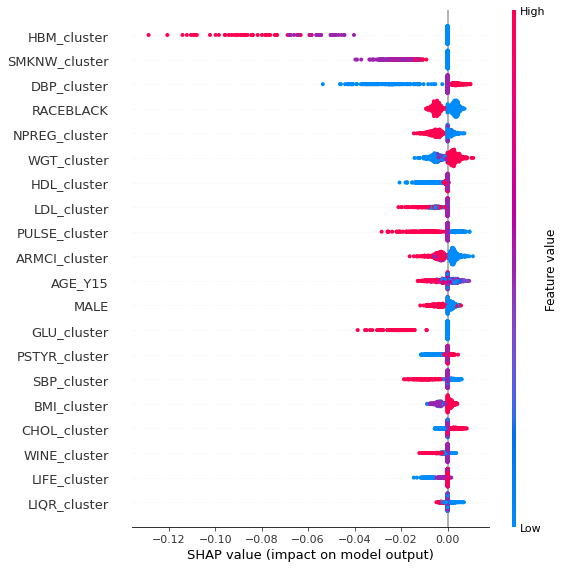

In [24]:
shap.initjs()
shap.summary_plot(loaded_kmeans_shaps.to_numpy(), featurespace_test_df)


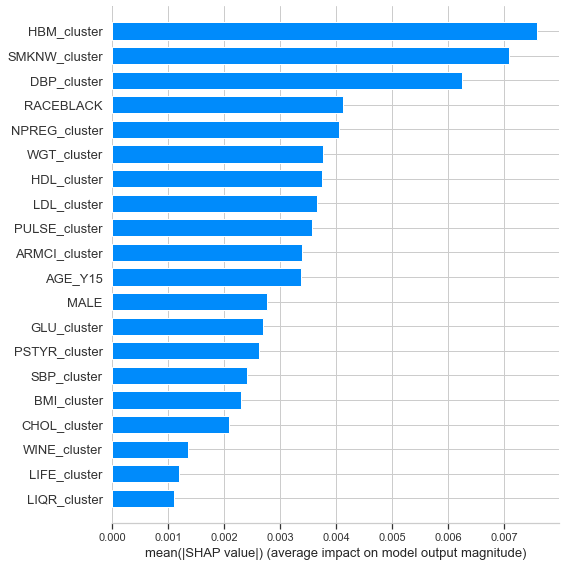

In [97]:
shap.summary_plot(loaded_kmeans_shaps, featurespace_test_df.iloc[:,:], plot_type = 'bar')


In [109]:
featurespace_test_df_wo_var_oi 

RACEBLACK  MALE  ASMA_cluster  BEER_cluster  CANCR_cluster  \
1             1     1             2             1              1   
3             1     1             2             1              1   
4             1     0             2             2              1   
5             1     1             2             1              1   
7             0     0             2             2              1   
...         ...   ...           ...           ...            ...   
3508          0     0             2             2              1   
3510          1     0             2             2              1   
3514          1     0             2             2              1   
3519          0     0             2             2              1   
3534          1     1             1             2              1   

      CGTDY_cluster  DIAB_cluster  GALL_cluster  KIDNY_cluster  LIFE_cluster  \
1                 2             2             3              2             3   
3                 2             2             3              2             3   
4                 1             2             2              2             2   
5                 2             2             3              2             3   
7                 2             3             3              1             2   
...             ...           ...           ...            ...           ...   
3508              2             2             3              2             3   
3510              2             2             3              2             3   
3514              2             2             3              2             3   
3519              2             2             3              2             3   
3534              2             2             3              2             3   

      ...  PSTYR_cluster  PULSE_cluster  WGT_cluster  WST_cluster  \
1     ...              3              2            3            2   
3     ...              2              2            1            2   
4     ...              3              3            1            2   
5     ...              2              2            2            3   
7     ...              3              1            1            1   
...   ...            ...            ...          ...          ...   
3508  ...              1              3            3            1   
3510  ...              3              2            1            2   
3514  ...              1              2            2            2   
3519  ...              3              2            1            1   
3534  ...              3              3            1            1   

      DBP_cluster  SBP_cluster  AGE_Y15  CHNOW_cluster  PATCK_cluster  \
1               1            2       43              0              0   
3               2            2       35              0              0   
4               2            2       43              0              0   
5               1            3       34              0              0   
7               3            2       45              0              1   
...           ...          ...      ...            ...            ...   
3508            3            1       39              0              0   
3510            2            3       44              0              1   
3514            3            2       42              0              0   
3519            3            1       43              0              0   
3534            2            2       41              0              0   

      LIVER_cluster  
1                 0  
3                 0  
4                 0  
5                 0  
7                 0  
...             ...  
3508              0  
3510              0  
3514              0  
3519              0  
3534              0  

[711 rows x 34 columns]

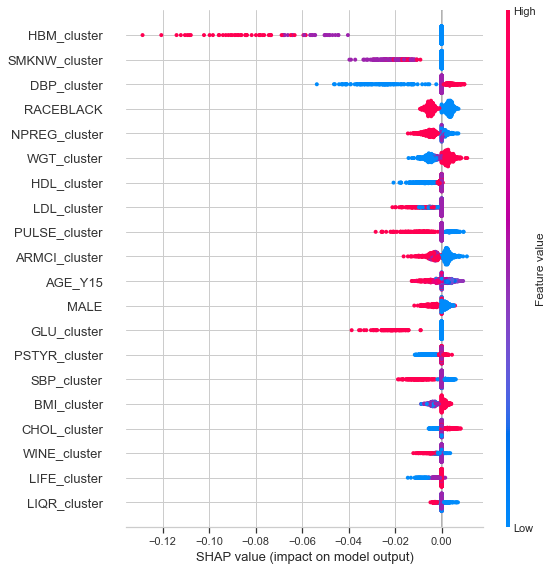

In [116]:
kmeans_shaps_wo_var_oi = loaded_kmeans_shaps.drop(loaded_kmeans_shaps.columns[idx_npreg], axis=1)#np.delete(loaded_kmeans_shaps, idx_npreg, 1)


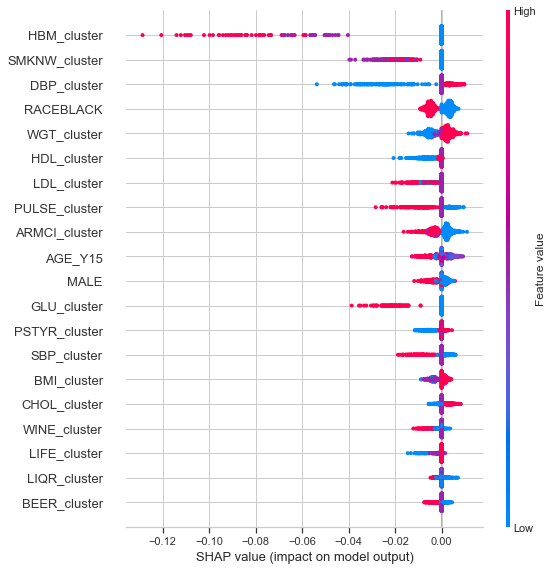

In [117]:
idx_npreg = featurespace_test_df.columns.get_loc('NPREG_cluster')

kmeans_shaps_wo_var_oi = loaded_kmeans_shaps.drop(loaded_kmeans_shaps.columns[idx_npreg], axis=1)#np.delete(loaded_kmeans_shaps, idx_npreg, 1)
featurespace_test_df_wo_var_oi = featurespace_test_df.drop(featurespace_test_df.columns[idx_npreg], axis=1)


shap.summary_plot(kmeans_shaps_wo_var_oi.to_numpy(), featurespace_test_df_wo_var_oi)


In [28]:
loaded_kmeans_shaps

RACEBLACK      MALE  ASMA_cluster  BEER_cluster  CANCR_cluster  \
0    -0.005764 -0.004564       0.00000      0.000000            0.0   
1    -0.005448 -0.003340       0.00000     -0.000447            0.0   
2    -0.003789  0.002370       0.00000      0.000000            0.0   
3    -0.005222 -0.001425       0.00000      0.000000            0.0   
4     0.002032  0.003026       0.00000      0.000000            0.0   
..         ...       ...           ...           ...            ...   
706   0.003368  0.001510       0.00000      0.000000            0.0   
707  -0.005770  0.000000       0.00000      0.000000            0.0   
708  -0.007428  0.000000       0.00000      0.000000            0.0   
709   0.002319  0.003102       0.00000      0.000000            0.0   
710  -0.004368 -0.004149      -0.00835      0.000000            0.0   

     CGTDY_cluster  DIAB_cluster  GALL_cluster  KIDNY_cluster  LIFE_cluster  \
0         0.000000       0.00000      0.000000       0.000000      0.000000   
1         0.000000       0.00000      0.000000       0.000000      0.000000   
2         0.000618       0.00000     -0.000818       0.000000     -0.002476   
3         0.000000       0.00000      0.000000       0.000000      0.000000   
4         0.000000      -0.00137      0.000000      -0.007978     -0.001263   
..             ...           ...           ...            ...           ...   
706       0.000000       0.00000      0.000000       0.000000      0.000000   
707       0.000000       0.00000      0.000000       0.000000      0.000000   
708       0.000000       0.00000      0.000000       0.000000      0.000000   
709       0.000000       0.00000      0.000000       0.000000      0.000000   
710       0.000000       0.00000      0.000000       0.000000      0.000000   

     ...  PSTYR_cluster  PULSE_cluster  WGT_cluster  WST_cluster  DBP_cluster  \
0    ...       0.000000       0.000000     0.001374    -0.001583    -0.020667   
1    ...       0.000000       0.000000    -0.002490    -0.000425     0.000000   
2    ...       0.000000      -0.014130    -0.003790    -0.000639     0.000000   
3    ...       0.000000       0.000000     0.000000     0.000000    -0.022217   
4    ...      -0.000463       0.003703    -0.002947     0.000000     0.003032   
..   ...            ...            ...          ...          ...          ...   
706  ...      -0.004238      -0.007322     0.002816     0.000000     0.003259   
707  ...       0.001952       0.000000    -0.007346     0.000000     0.000000   
708  ...      -0.007892       0.000000    -0.000805     0.000000     0.005514   
709  ...      -0.000970       0.000000    -0.003400     0.000567     0.004269   
710  ...      -0.000332      -0.006175    -0.004129     0.000000     0.000000   

     SBP_cluster   AGE_Y15  CHNOW_cluster  PATCK_cluster  LIVER_cluster  
0       0.000000  0.000000            0.0       0.000000            0.0  
1       0.000000  0.001781            0.0       0.000000            0.0  
2       0.000000 -0.001562            0.0       0.000000            0.0  
3      -0.008169  0.000000            0.0       0.000000            0.0  
4       0.000000 -0.005606            0.0      -0.004678            0.0  
..           ...       ...            ...            ...            ...  
706     0.001569  0.002377            0.0       0.000000            0.0  
707    -0.009891 -0.007654            0.0      -0.003454            0.0  
708     0.000000 -0.000468            0.0       0.000000            0.0  
709     0.001503 -0.000860            0.0       0.000000            0.0  
710     0.000000  0.002915            0.0       0.000000            0.0  

[711 rows x 35 columns]

In [52]:
shap.initjs()
shap.force_plot(explainer_kmeans.expected_value, kmeans_shaps[0],featurespace_test_df.iloc[0,:])


In [51]:
shap.initjs()
shap.force_plot(explainer_kmeans.expected_value, kmeans_shaps[8],featurespace_test_df.iloc[8,:])


In [68]:
y_test[1:,]

array([(False, 17.05749487), (False, 17.42436687), (False, 17.38603696),
       (False, 17.12594114), (False, 17.36687201), (False, 17.37234771),
       (False, 17.15058179), (False, 16.97535934), (False, 17.34770705),
       ( True, 11.78439425), (False, 17.26009582), (False, 17.14236824),
       (False, 17.39698836), (False,  9.62696783), (False, 17.183436  ),
       (False, 16.89048597), (False, 17.26009582), (False, 16.88501027),
       (False, 16.88501027), (False, 17.3340178 ), ( True, 11.40930869),
       (False, 17.19712526), (False, 17.85420945), (False, 17.3394935 ),
       ( True, 16.60027379), (False, 17.02190281), (False, 16.92060233),
       (False, 16.92060233), ( True,  6.34976044), (False, 17.1724846 ),
       (False, 17.08487337), (False, 17.15879535), (False, 17.03559206),
       (False, 17.04106776), (False, 16.88501027), (False, 16.88774812),
       (False, 10.14442163), (False, 17.04654346), (False, 17.10130048),
       (False, 17.06023272), (False, 17.03011636), 

In [77]:
featurespace_test_df.iloc[41:50,:]

RACEBLACK  MALE  ASMA_cluster  BEER_cluster  CANCR_cluster  \
187          1     1             2             2              1   
198          1     1             2             2              1   
199          0     1             3             2              1   
201          1     0             2             3              3   
204          1     1             2             3              1   
212          0     0             2             3              1   
214          0     0             2             1              1   
217          0     1             2             2              1   
219          0     0             2             2              1   

     CGTDY_cluster  DIAB_cluster  GALL_cluster  KIDNY_cluster  LIFE_cluster  \
187              2             2             3              2             2   
198              3             2             3              2             1   
199              1             2             3              2             2   
201              2             3             3              2             3   
204              2             2             3              2             2   
212              2             2             3              2             2   
214              2             2             3              2             2   
217              2             2             3              2             2   
219              2             2             1              3             2   

     ...  PSTYR_cluster  PULSE_cluster  WGT_cluster  WST_cluster  DBP_cluster  \
187  ...              3              1            1            3            1   
198  ...              2              2            1            2            1   
199  ...              1              2            3            1            3   
201  ...              2              2            1            1            2   
204  ...              2              2            3            1            3   
212  ...              2              3            3            1            3   
214  ...              1              2            3            2            3   
217  ...              3              2            1            2            2   
219  ...              2              1            2            3            3   

     SBP_cluster  AGE_Y15  CHNOW_cluster  PATCK_cluster  LIVER_cluster  
187            1       37              0              1              0  
198            2       45              0              0              0  
199            1       37              0              0              0  
201            2       42              0              1              0  
204            1       37              0              0              0  
212            1       35              0              0              0  
214            2       42              0              0              0  
217            1       34              0              1              0  
219            1       36              0              0              0  

[9 rows x 35 columns]

In [85]:
test_df.reset_index()[test_df.reset_index()['event'] ==1]

index  event       time  RACEBLACK  MALE  ASMA_cluster  BEER_cluster  \
10      41      1  11.784394          0     1             2             2   
21      99      1  11.409309          1     0             2             1   
25     121      1  16.600274          0     1             2             1   
29     127      1   6.349760          1     0             1             3   
68     291      1   7.518823          1     0             2             1   
73     312      1  14.089665          0     1             2             1   
75     321      1   5.084873          1     1             2             1   
81     346      1   2.330595          1     1             2             1   
84     353      1  17.041068          1     1             2             2   
95     399      1   7.787132          1     1             2             2   
111    465      1   3.986995          1     0             1             2   
122    509      1   8.134839          1     1             3             2   
133    567      1  11.584531          1     1             2             1   
141    619      1   8.824778          0     1             2             2   
146    652      1   6.440110          1     0             2             2   
153    667      1   2.511294          1     1             2             1   
162    693      1  14.065024          1     0             2             1   
163    695      1  14.459274          1     1             2             2   
197    903      1  12.832991          1     0             2             2   
200    908      1   5.774812          1     1             2             1   
219   1023      1  15.803559          0     0             2             2   
267   1310      1   4.307324          1     0             3             1   
281   1395      1   3.622861          1     0             3             2   
285   1413      1  15.231348          0     1             2             2   
301   1477      1   8.915127          1     1             2             2   
356   1760      1   2.568789          1     0             2             3   
424   2128      1  12.739904          0     0             2             3   
456   2248      1   9.722793          0     1             2             3   
477   2347      1  12.422313          1     1             2             1   
501   2455      1  15.699521          0     0             2             1   
526   2589      1  11.694045          1     1             2             2   
566   2848      1   6.273101          1     0             2             1   
647   3223      1  12.709788          1     1             2             3   
656   3266      1  15.924025          1     1             2             2   
657   3271      1  13.761123          1     0             2             2   
669   3345      1  12.871321          0     1             2             2   
690   3447      1   6.924709          1     0             3             2   
696   3482      1  16.003422          0     1             2             3   

     CANCR_cluster  CGTDY_cluster  DIAB_cluster  ...  PSTYR_cluster  \
10               1              1             2  ...              2   
21               1              2             2  ...              1   
25               1              2             2  ...              3   
29               1              1             1  ...              1   
68               1              2             2  ...              1   
73               1              2             2  ...              3   
75               1              2             2  ...              2   
81               1              2             2  ...              2   
84               1              2             2  ...              3   
95               1              2             2  ...              1   
111              1              3             2  ...              3   
122              1              2             2  ...              1   
133              1              1             2  ...              1   
141    

In [86]:
test_df.reset_index()[test_df.reset_index()['event'] ==1].index

Int64Index([ 10,  21,  25,  29,  68,  73,  75,  81,  84,  95, 111, 122, 133,
            141, 146, 153, 162, 163, 197, 200, 219, 267, 281, 285, 301, 356,
            424, 456, 477, 501, 526, 566, 647, 656, 657, 669, 690, 696],
           dtype='int64')

In [71]:
shap.initjs()
shap.force_plot(explainer_kmeans.expected_value, kmeans_shaps[41],featurespace_test_df.iloc[41,:])


In [82]:
shap.initjs()
shap.force_plot(explainer_kmeans.expected_value, kmeans_shaps[68],featurespace_test_df.iloc[68,:])


In [96]:
# idx_oi = test_df.reset_index()[test_df.reset_index()['event'] ==1].index
# for i in idx_oi[:2]:
shap.force_plot(explainer_kmeans.expected_value, kmeans_shaps[i],featurespace_test_df.iloc[i,:])


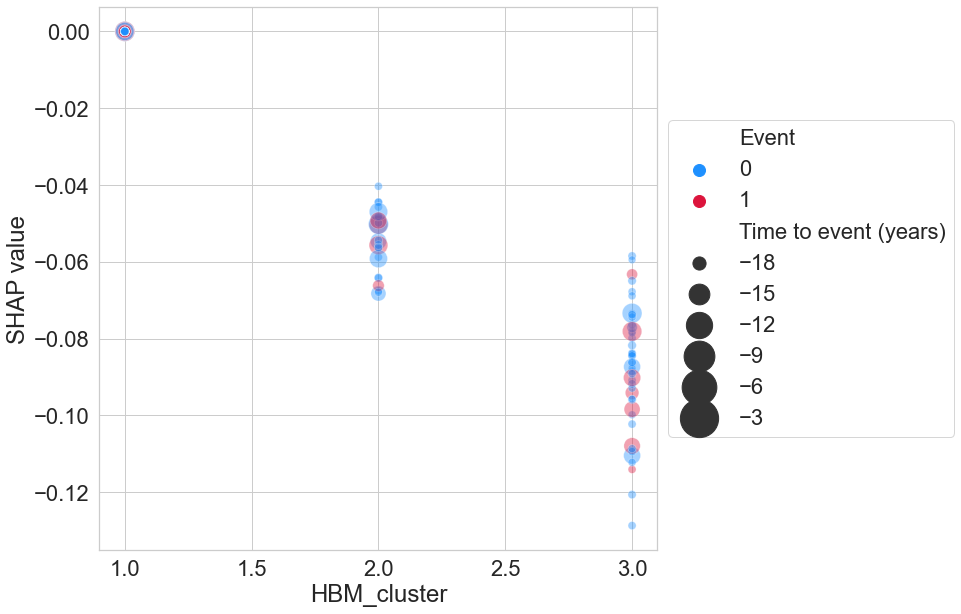

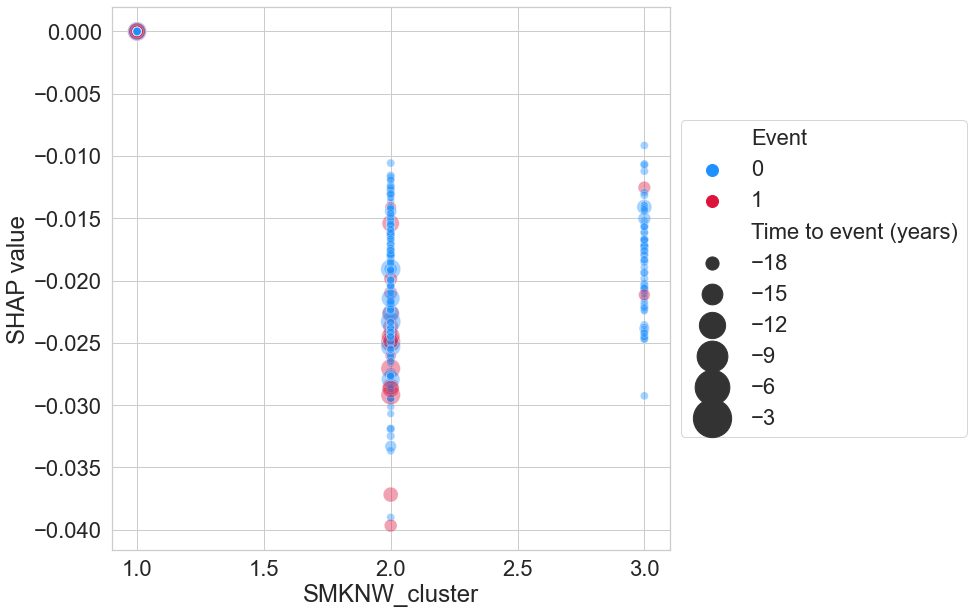

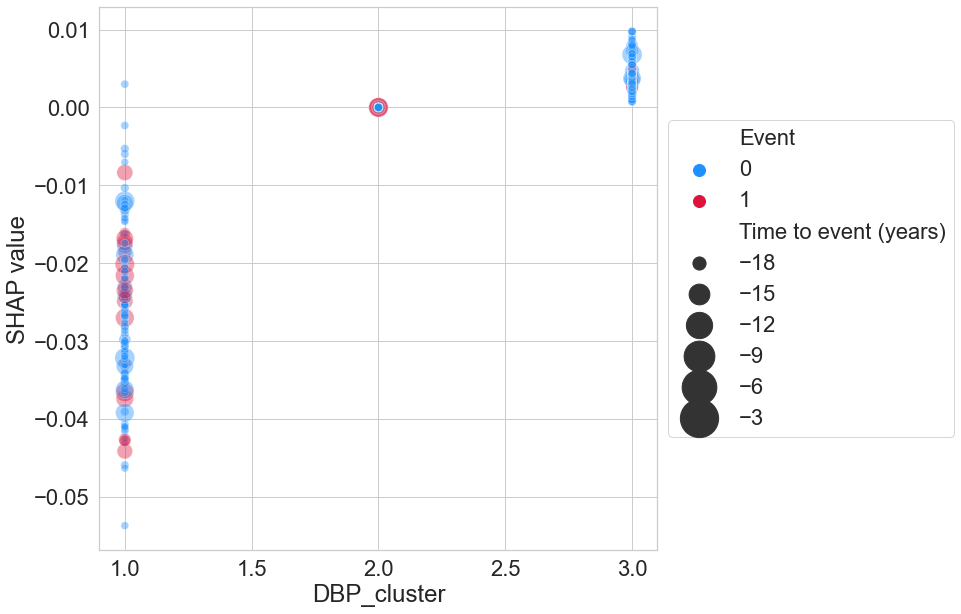

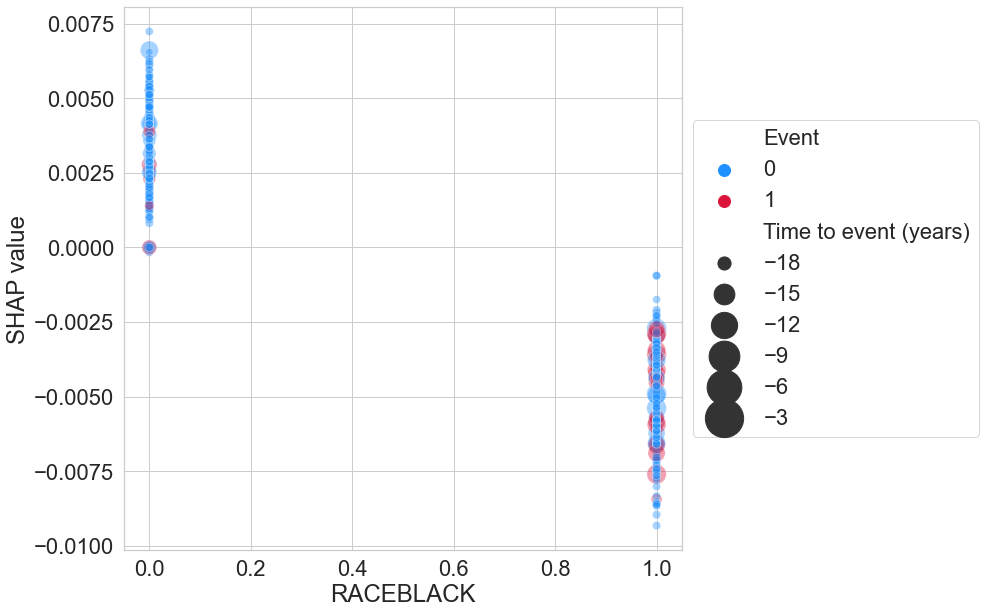

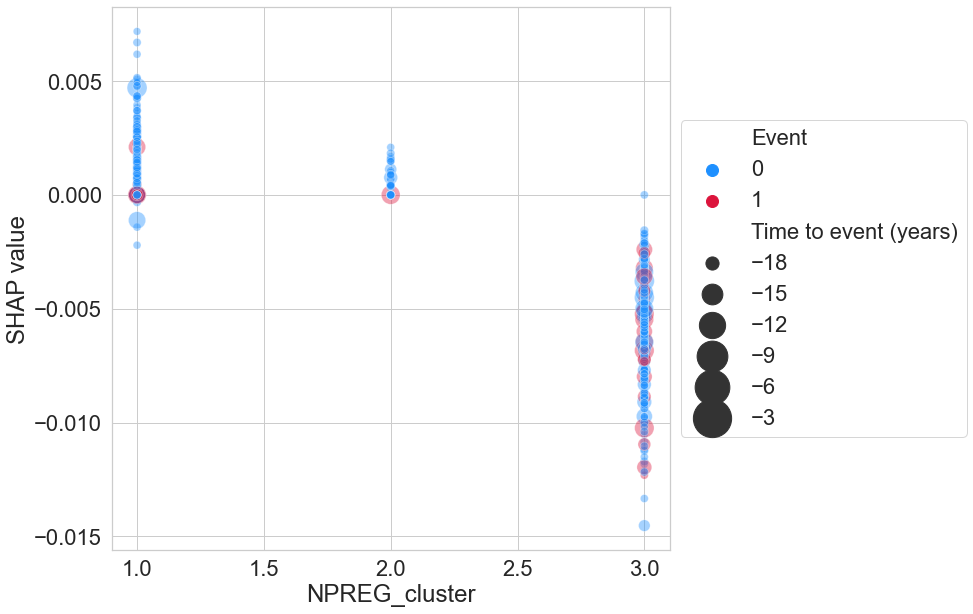

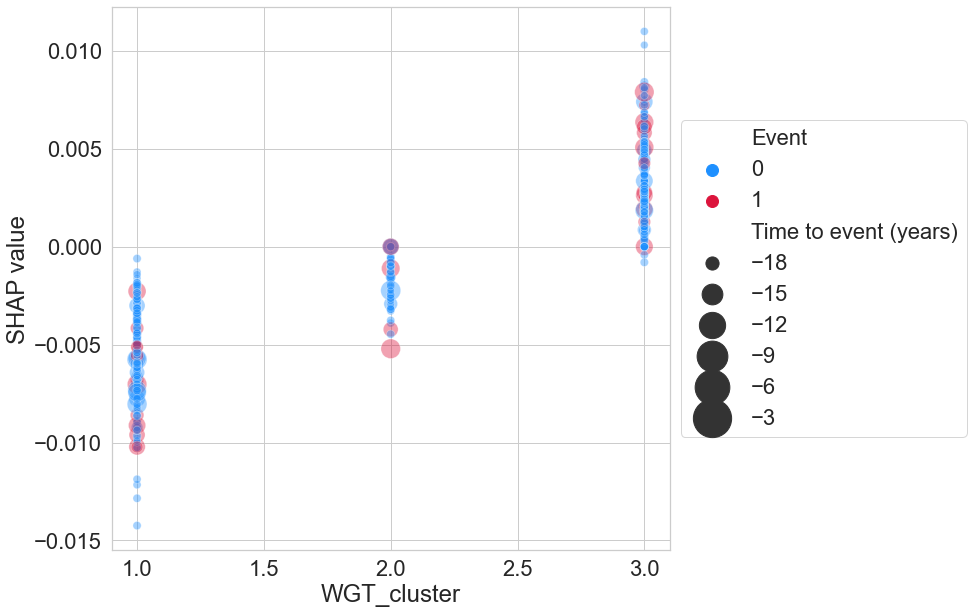

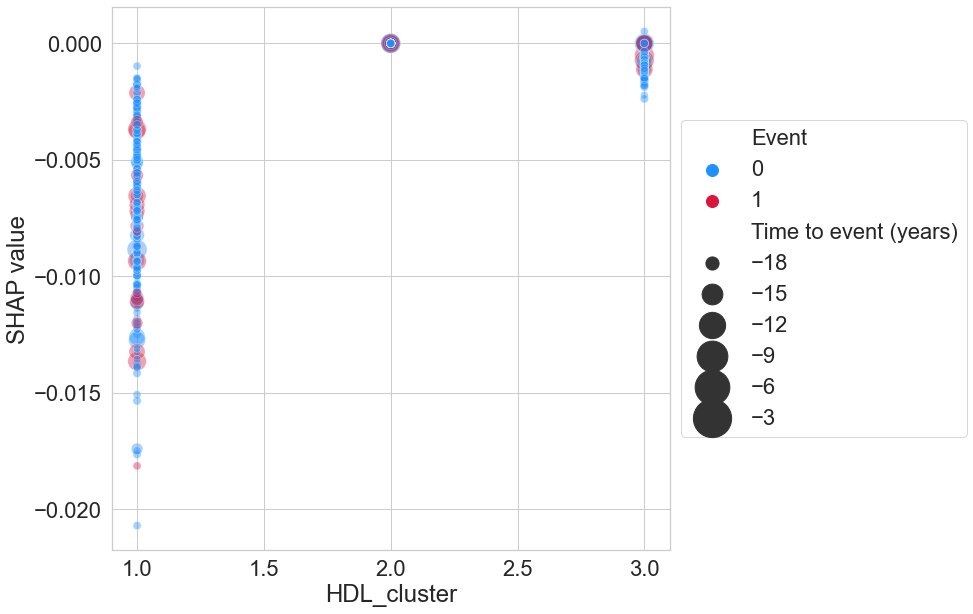

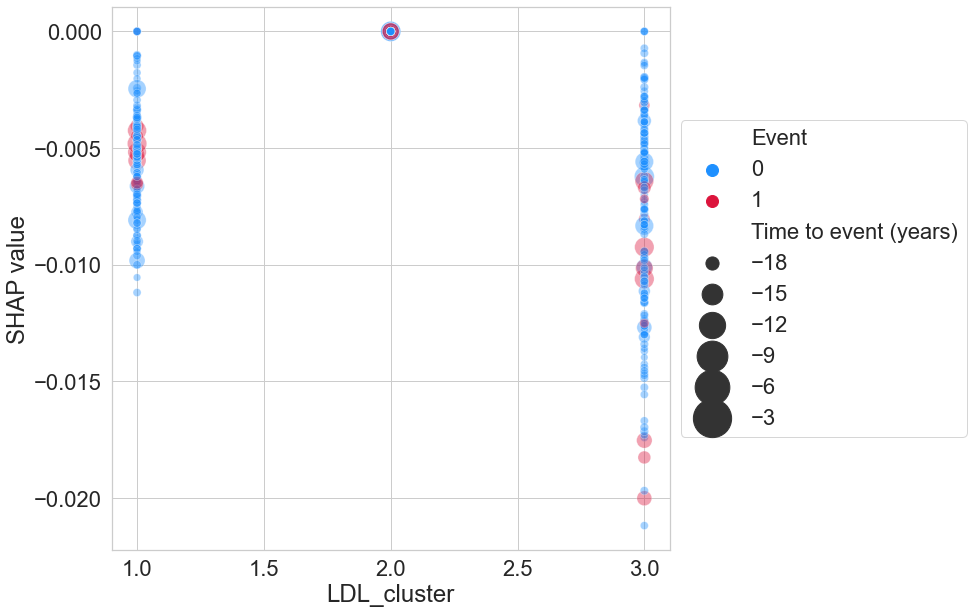

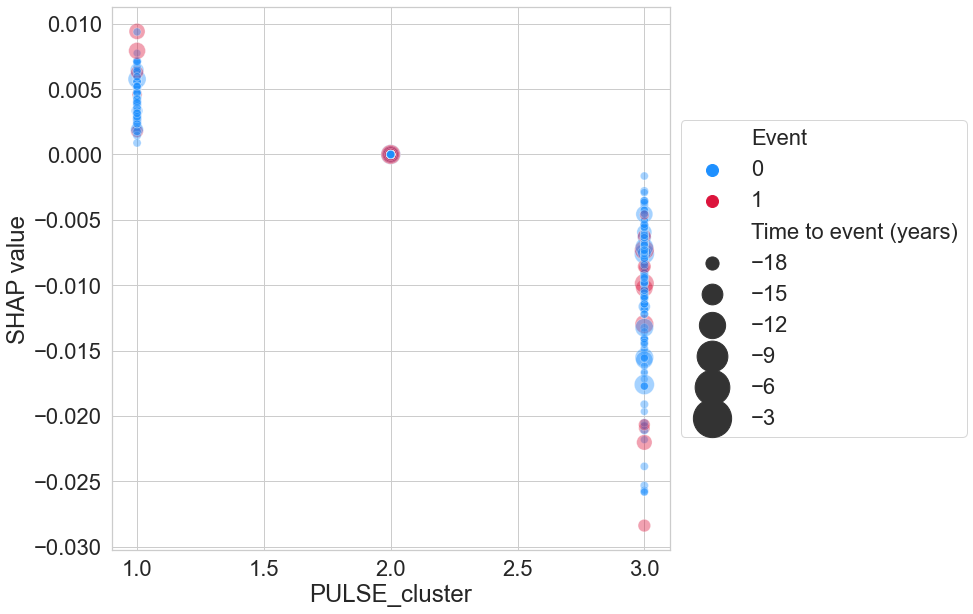

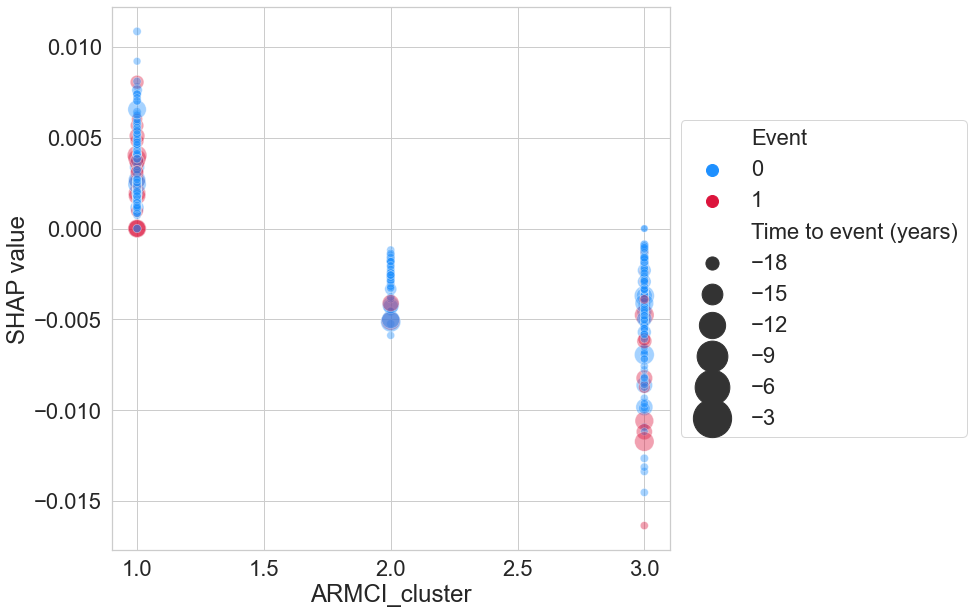

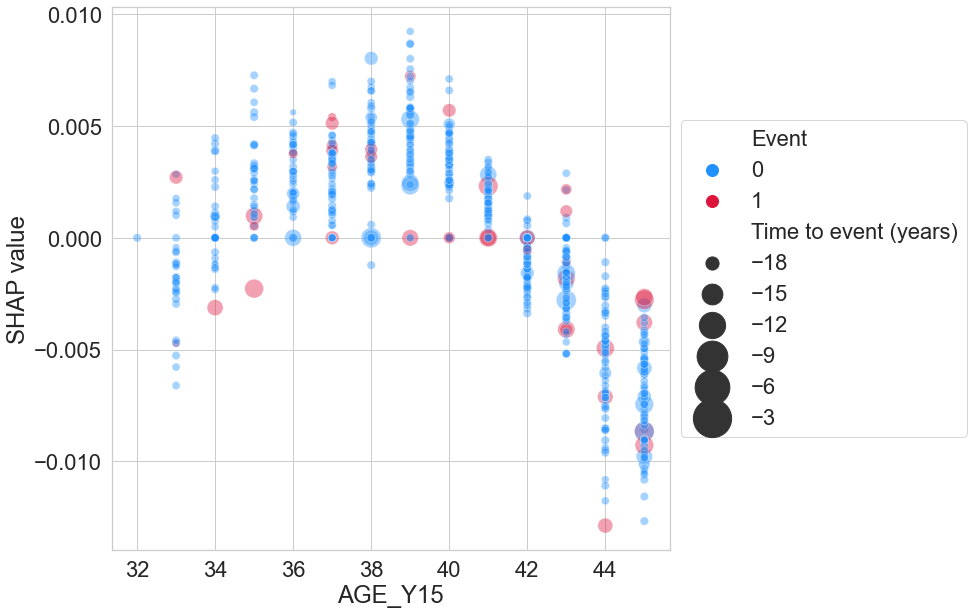

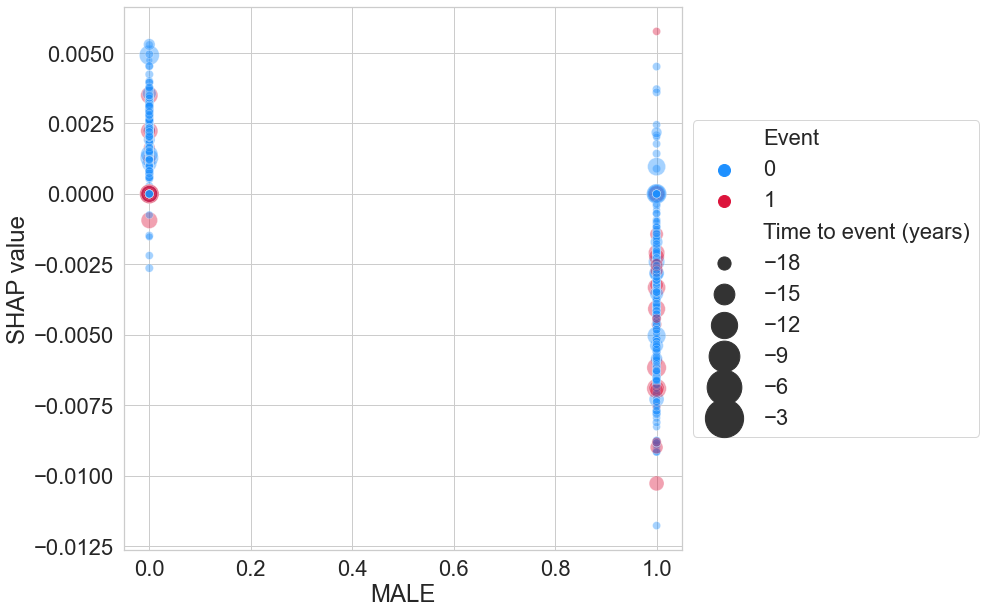

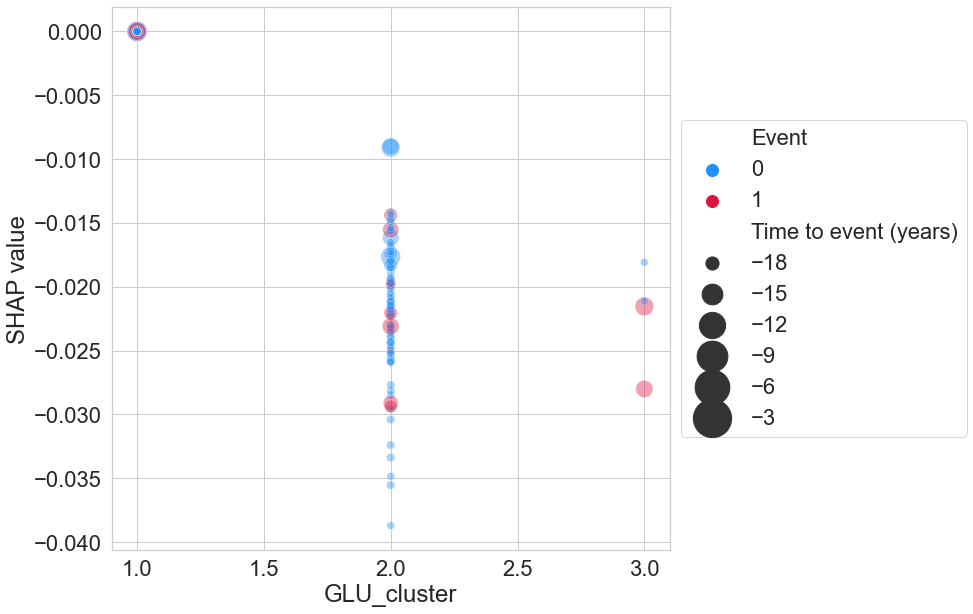

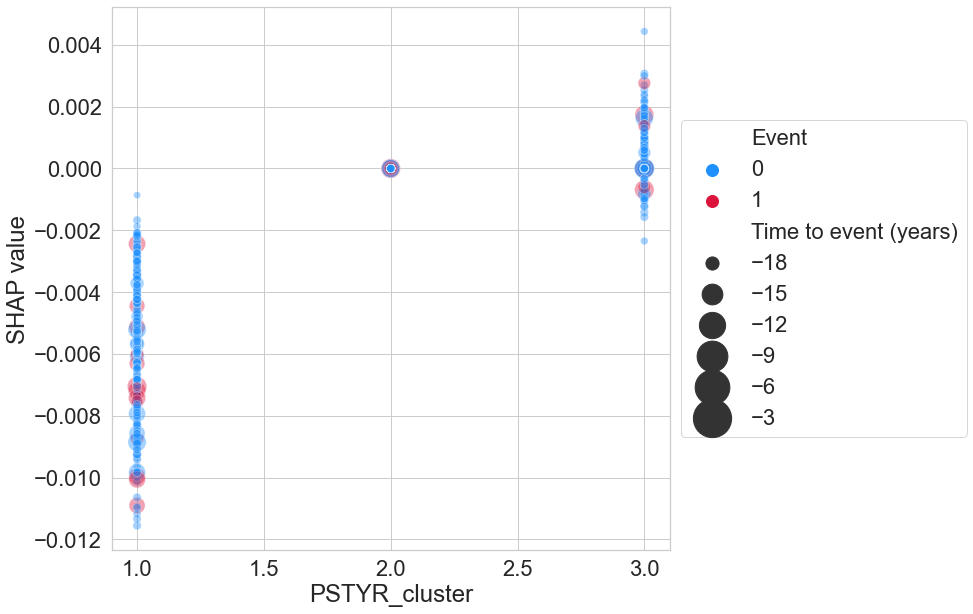

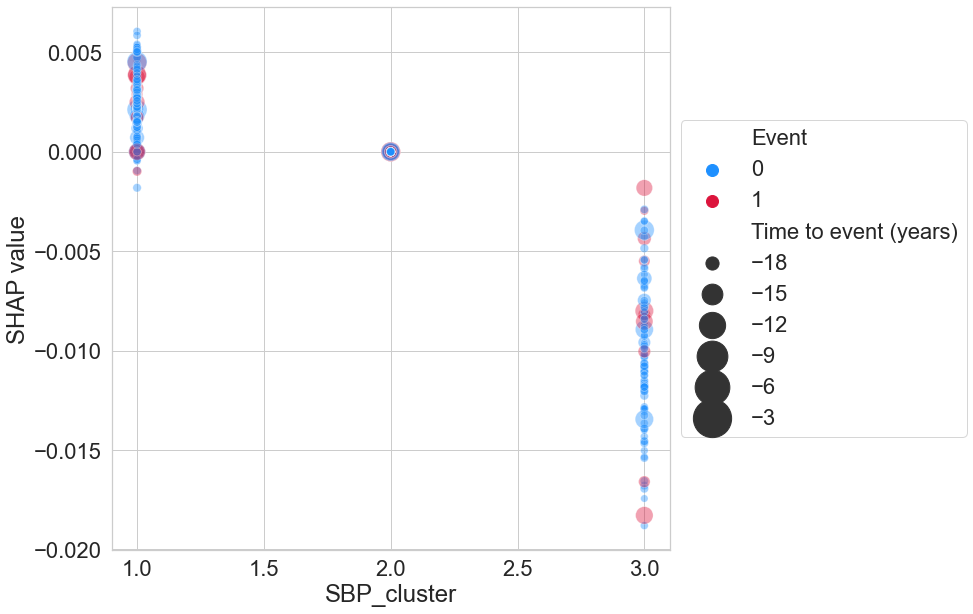

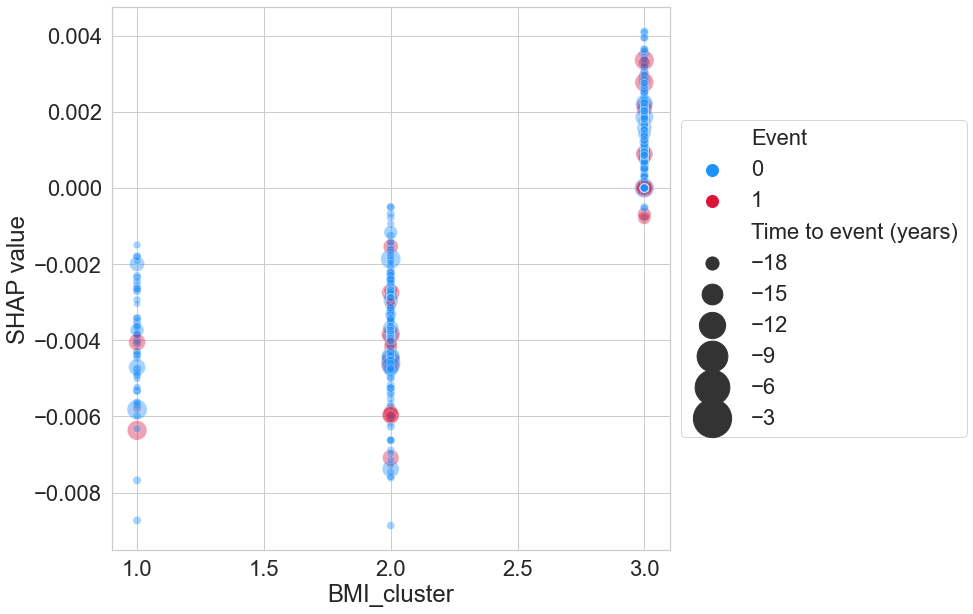

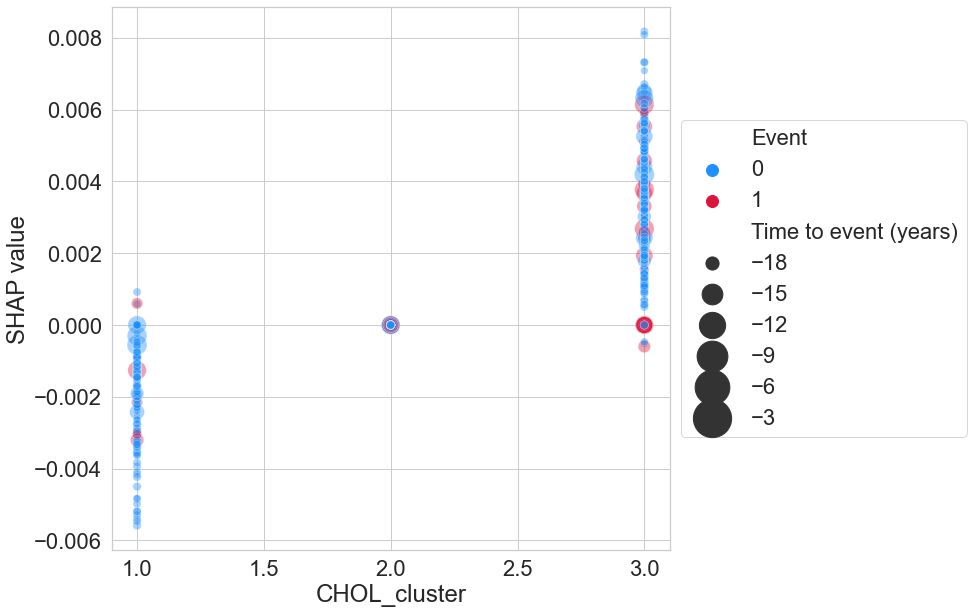

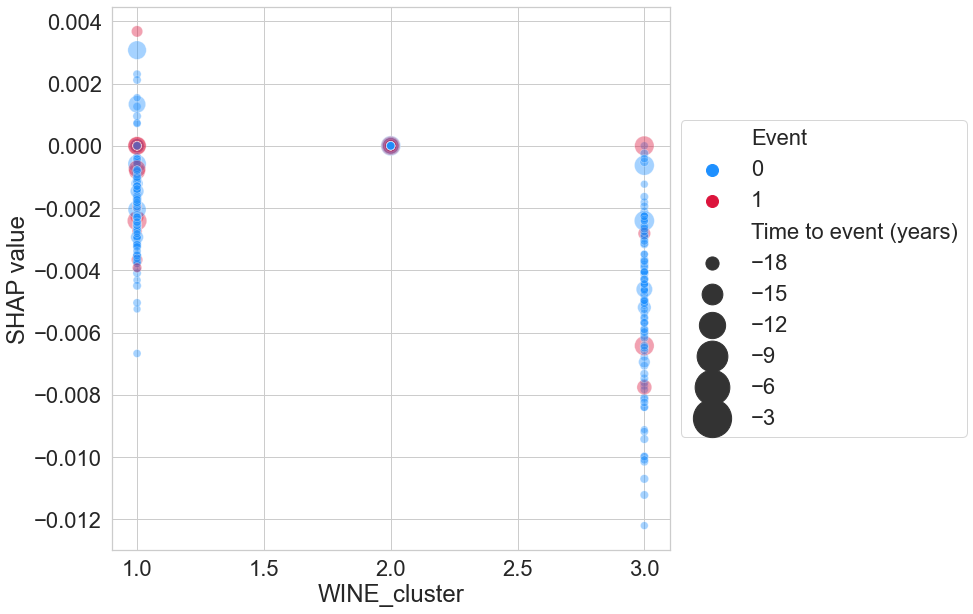

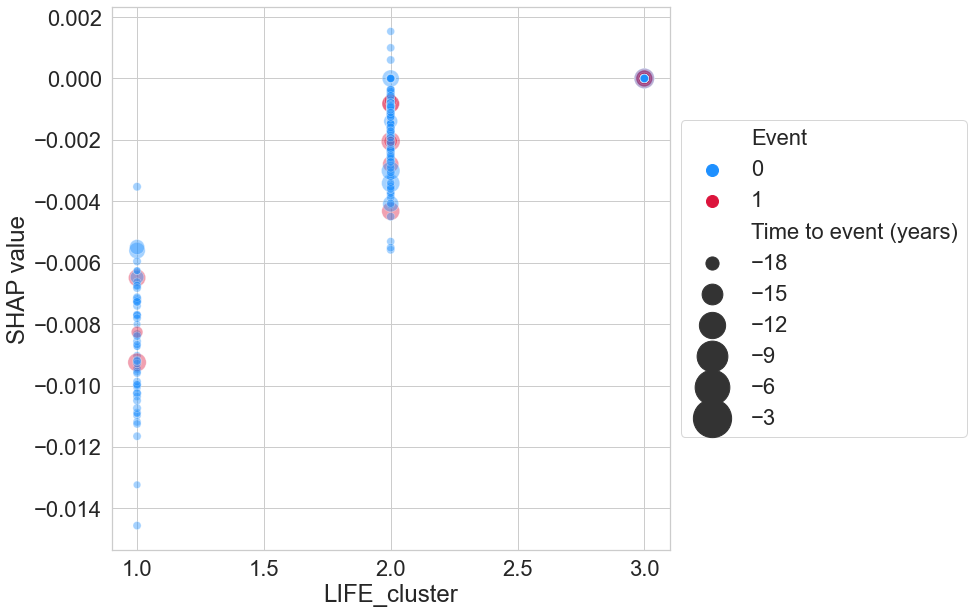

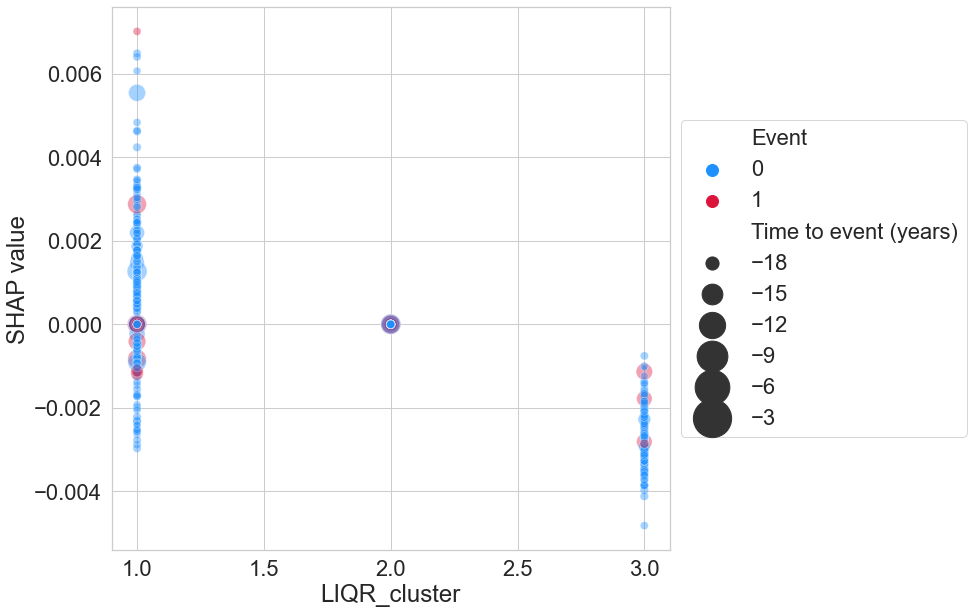

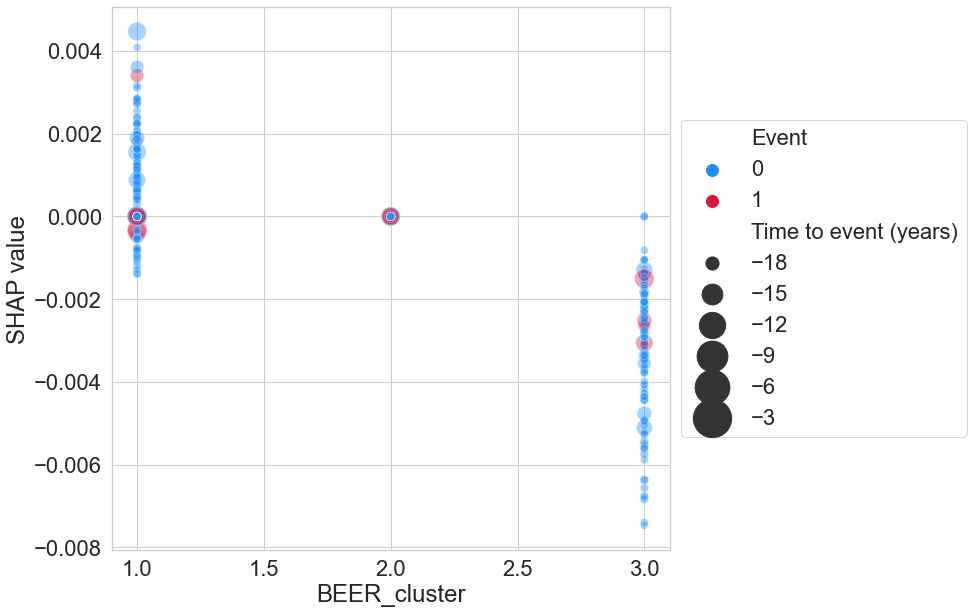

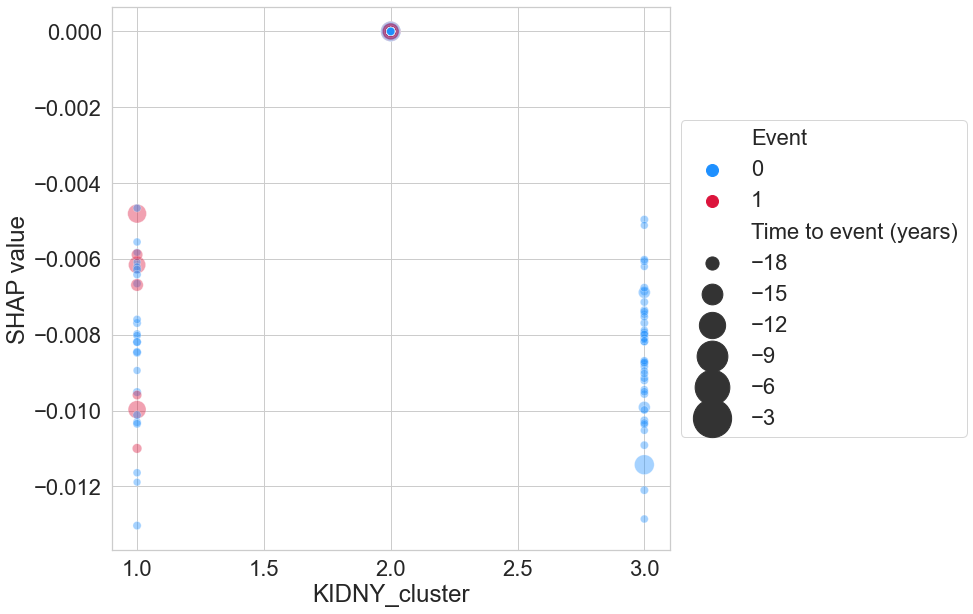

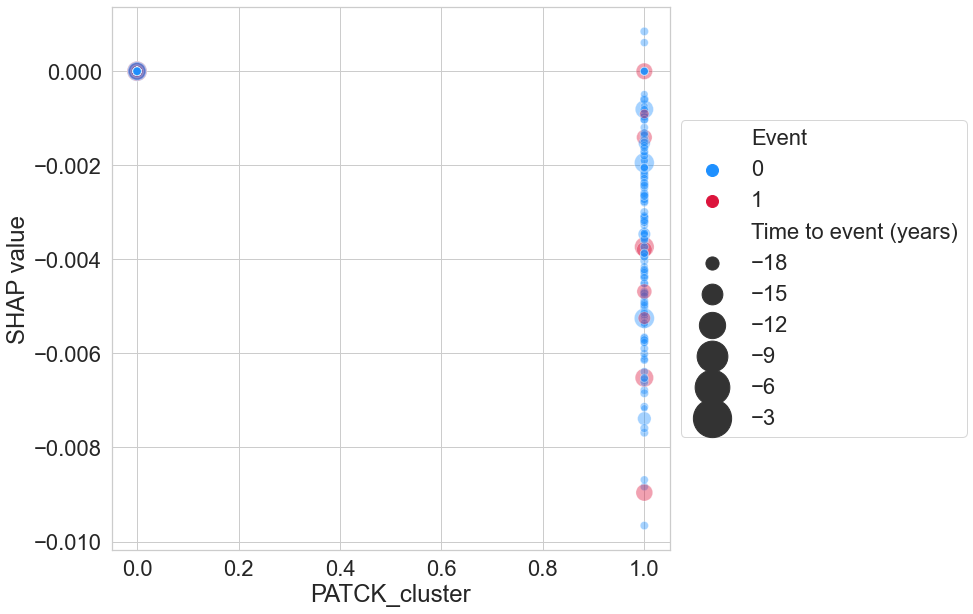

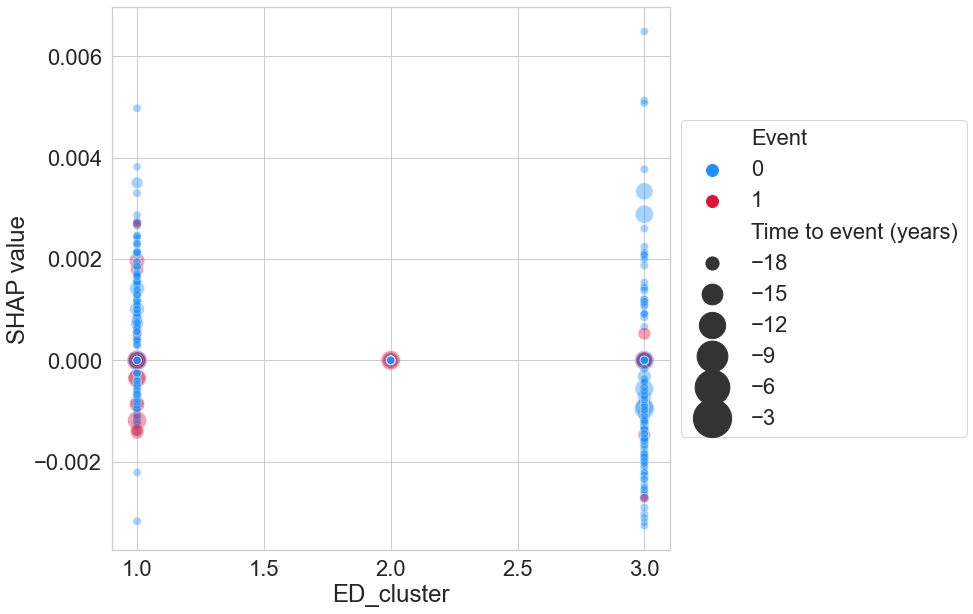

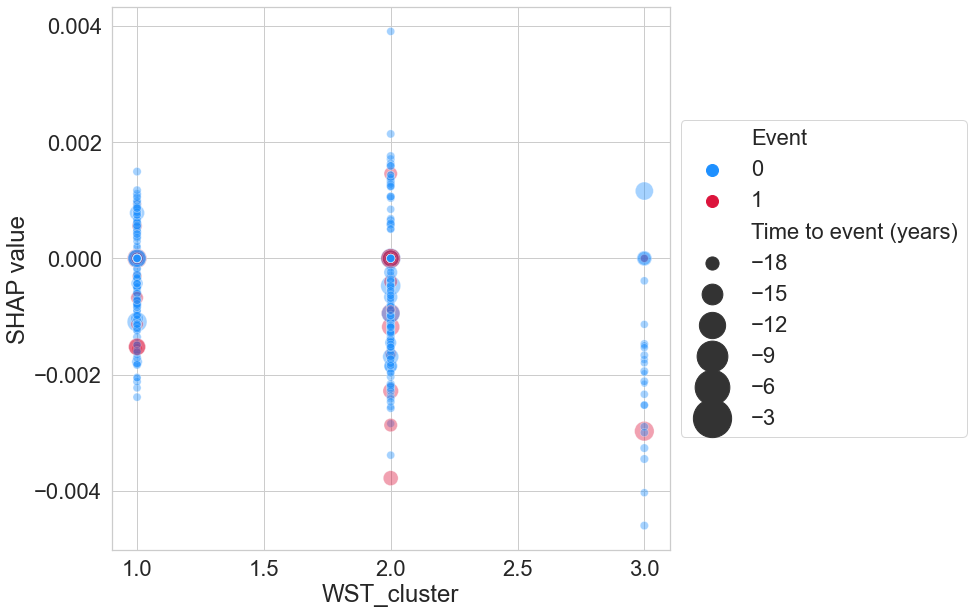

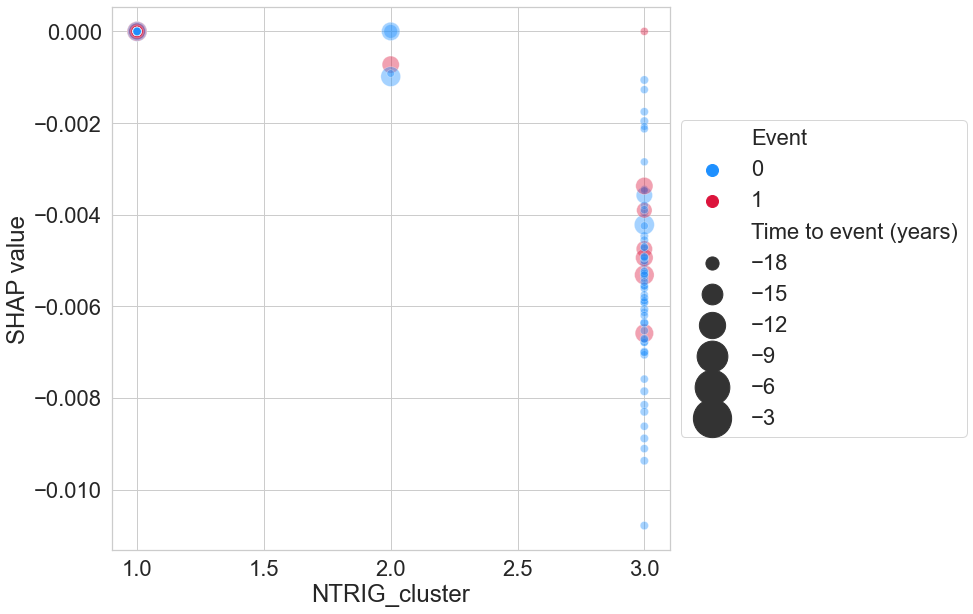

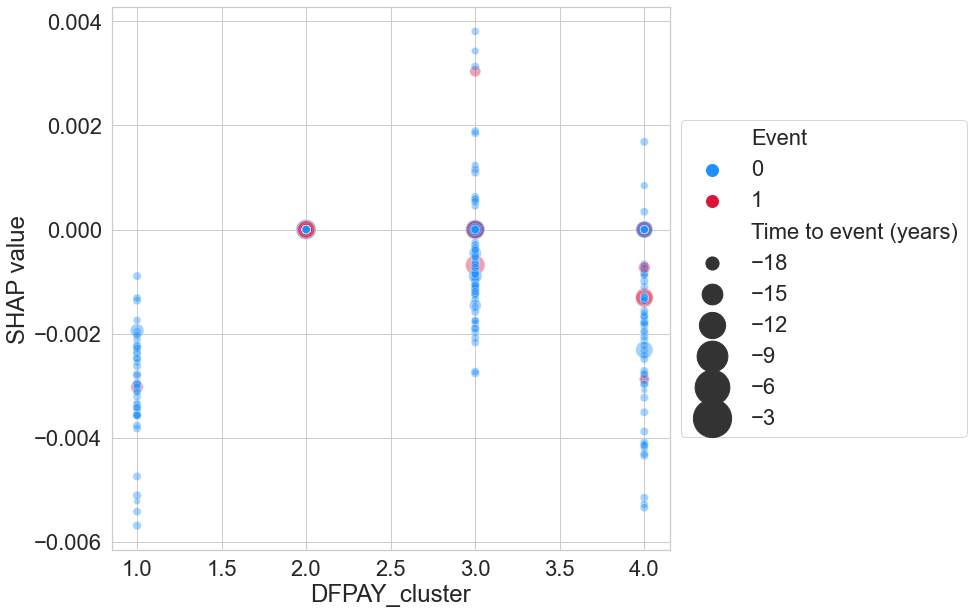

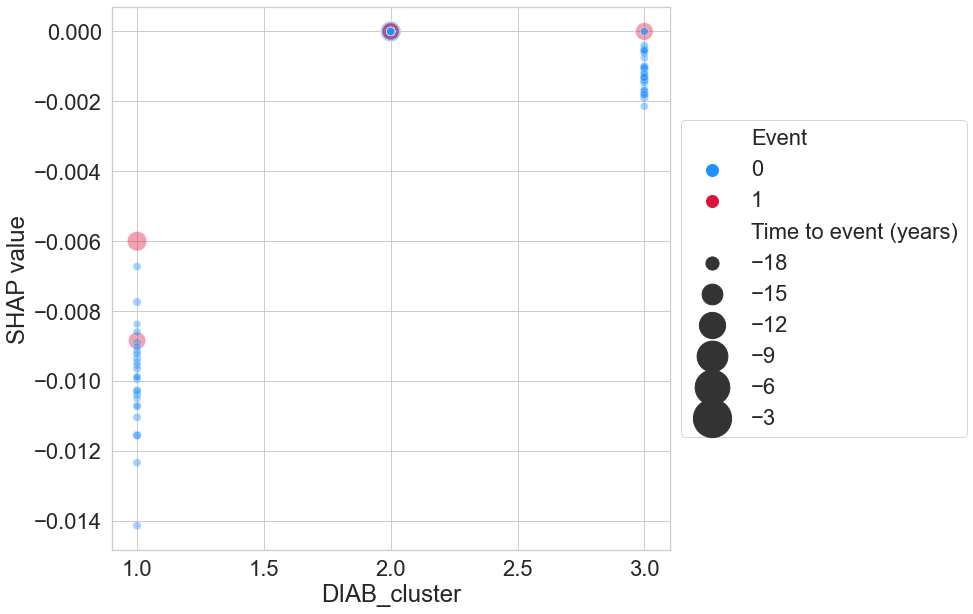

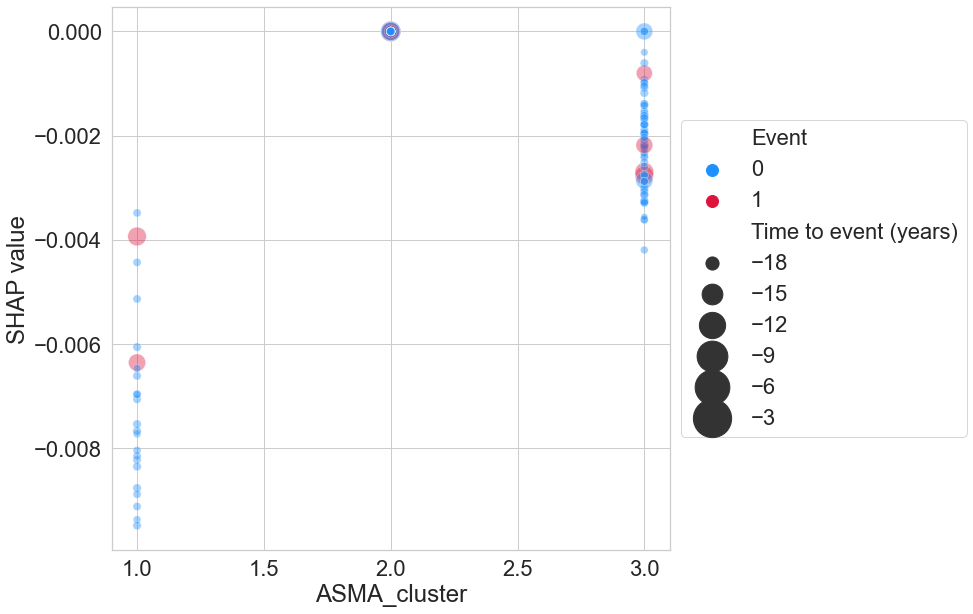

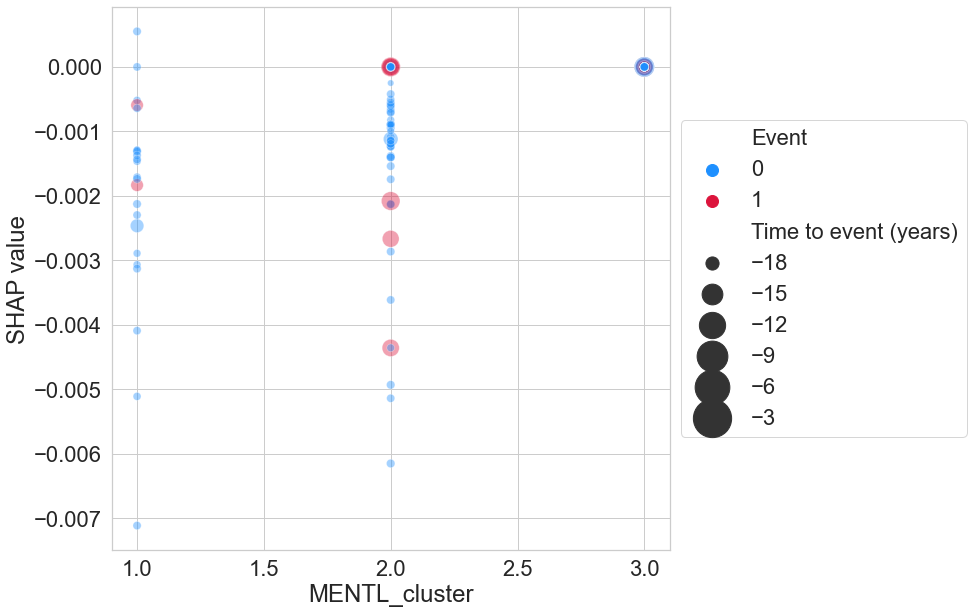

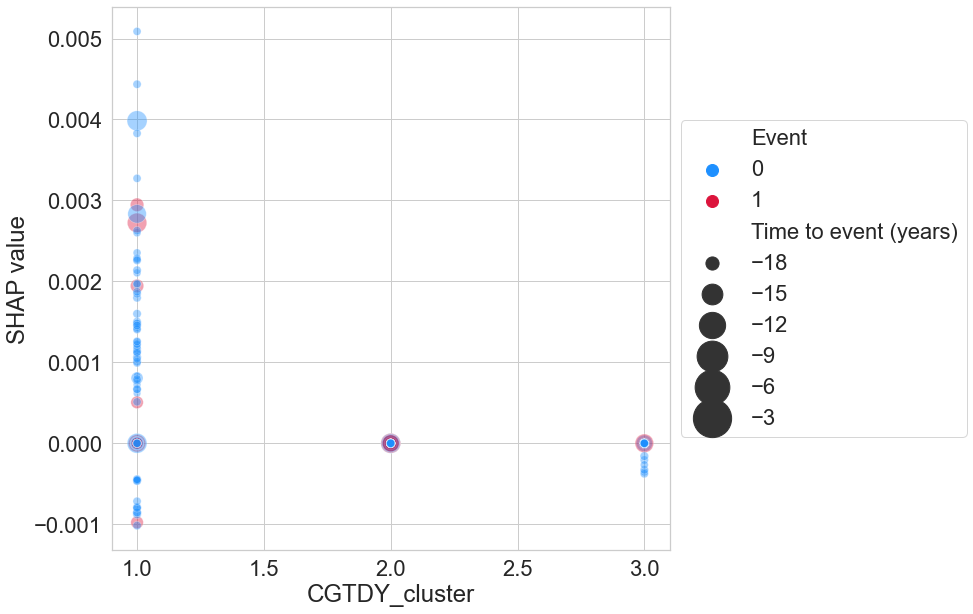

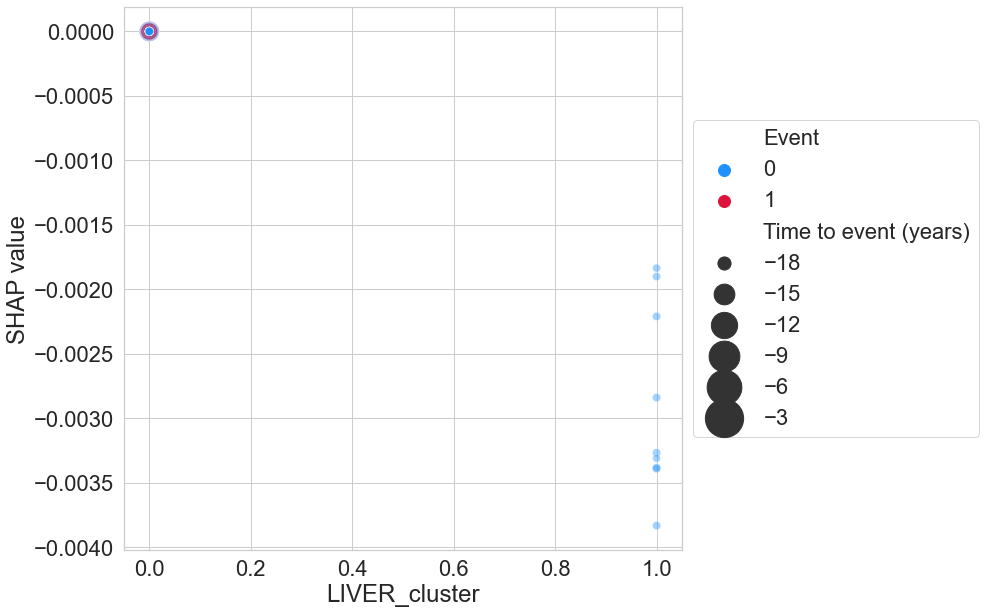

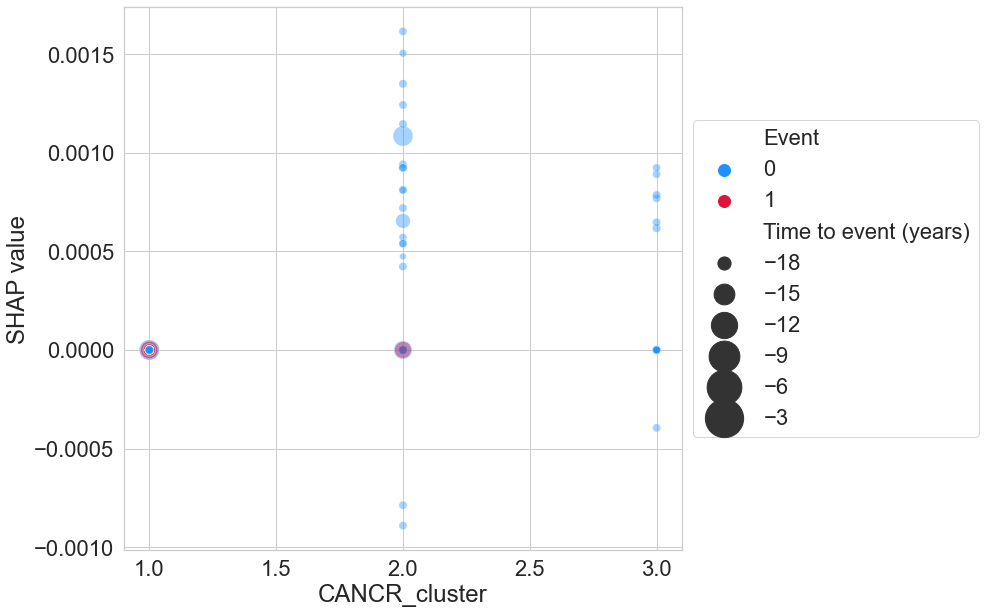

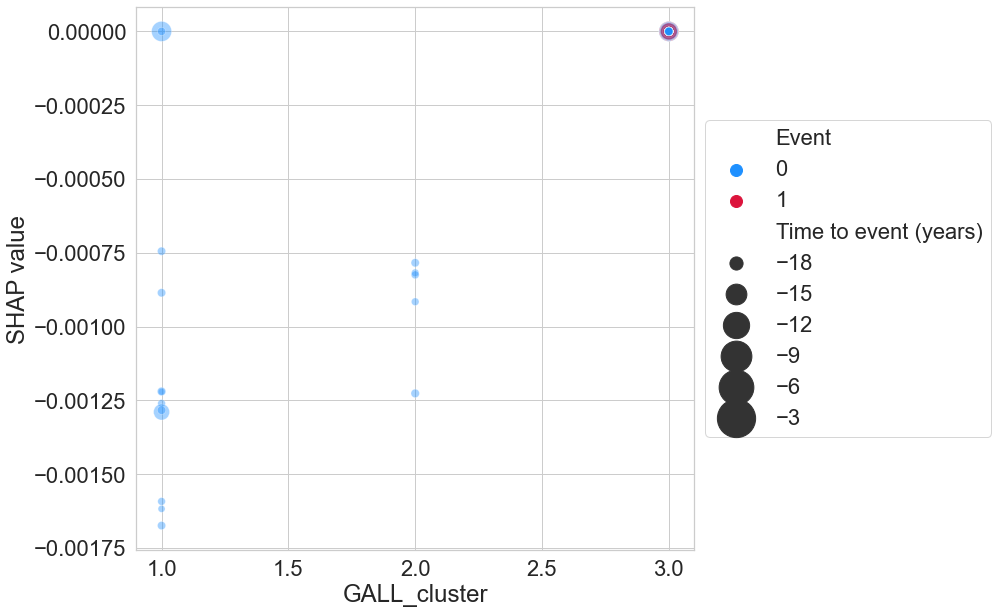

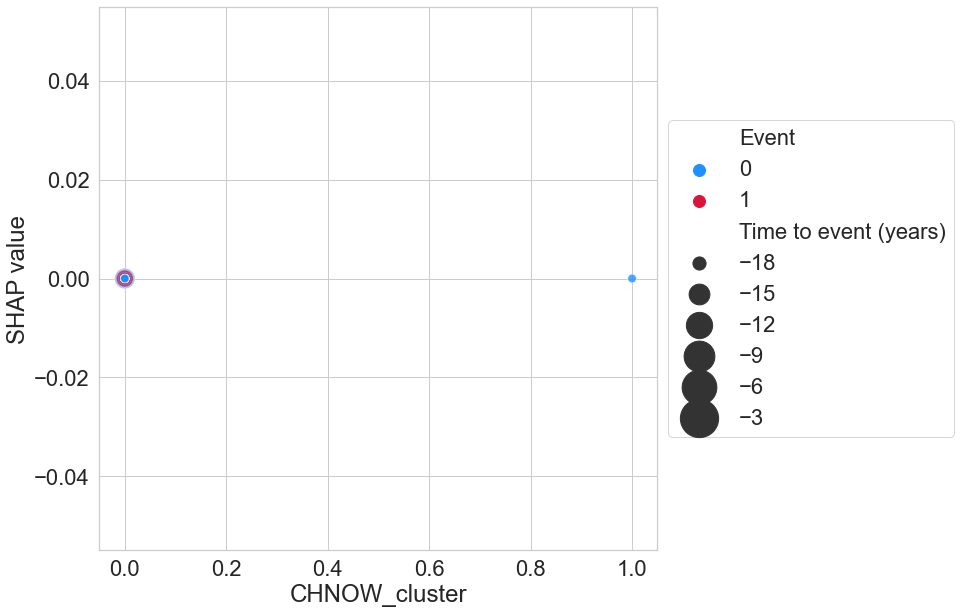

In [27]:
def plot_bubble_chart_SHAP(df, var, kmeans_shaps_=kmeans_shaps):

    idx_oi = df.columns.get_loc(var)
    df_for_bc = pd.DataFrame({df.columns[idx_oi]:df.iloc[:, idx_oi]
                             , 'SHAP value': kmeans_shaps_[:,idx_oi]
                             , 'event': test_df.event.values
                             , 'time': test_df.time.values})
    df_for_bc['Event'] = df_for_bc['event'].astype('category')

    df_for_bc['invert_time'] = -(df_for_bc['time'])
    df_for_bc['Time to event (years)'] = -(df_for_bc['time'])
    df_for_bc['Time to event (years)'] = -(df_for_bc['time'])


    import seaborn as sns
    sns.set(rc={'figure.figsize':(10,10)}, font_scale = 2, style = 'whitegrid')
    #sns.set()
    #fig, ax = plt.subplots(figsize=(10, 10))
    
    bc_plot = sns.scatterplot(data=df_for_bc
                    , x=df.columns[idx_oi]
                    , y='SHAP value'
                    , size= 'Time to event (years)'
                    , hue='Event', palette = ['dodgerblue', 'crimson']
                    , alpha=0.4, sizes=(40, 400)
                    # , ax = ax
                    #, legend = False
                    # , label = str(Time_in_years) + ' years'
                    )
    plt.legend(loc = 'center left', markerscale = 2
               , bbox_to_anchor = (1, 0.5))

    plt.show()

    
    
top_n_var = 35
top_var_names_arr = vimp_shap_kmeans.variable_name[:top_n_var].values
for i in range(top_n_var):
    plot_bubble_chart_SHAP(featurespace_test_df, top_var_names_arr[i], loaded_kmeans_shaps.to_numpy())
    

In [31]:
kmeans_shaps_all = explainer_kmeans.shap_values(data_full.drop(['time','event', 'ID'],axis =1))


In [32]:
vimp_shap_kmeans_all = vimp_shap_tabular(feature_name_list, np.abs(kmeans_shaps_all).mean(0))
vimp_shap_kmeans_all.to_csv(savedir+'/shap_kernel_explainer_expanded_var_2_all_subjects_fold_'+str(actual_fold)+'.csv', index = None, header = True)

kmeans_shaps_df_all = pd.DataFrame(kmeans_shaps_all)
kmeans_shaps_df_all.columns = featurespace_test_df.columns
pd.DataFrame(kmeans_shaps_df_all).to_csv(savedir+'/all_kmeans_shap_values_df_expanded_var_2_all_subjects_fold_'+str(actual_fold)+'.csv', index = None, header = True)

with open(savedir+'/explainer_kmeans_expected_values_2_all_subjects_fold_'+str(actual_fold)+'.txt', 'w') as f:
    f.write(str(explainer_kmeans.expected_value))


In [33]:
vimp_shap_kmeans_all

variable_name  normalized_vimp      vimp
15    HBM_cluster         1.000000  0.006824
13  SMKNW_cluster         0.997474  0.006807
29    DBP_cluster         0.962993  0.006572
12  NPREG_cluster         0.602512  0.004112
0       RACEBLACK         0.599882  0.004094
23    LDL_cluster         0.543960  0.003712
22    HDL_cluster         0.541901  0.003698
27    WGT_cluster         0.532489  0.003634
31        AGE_Y15         0.498814  0.003404
26  PULSE_cluster         0.494060  0.003372
16  ARMCI_cluster         0.488260  0.003332
21    GLU_cluster         0.465491  0.003177
1            MALE         0.407035  0.002778
25  PSTYR_cluster         0.390884  0.002667
17    BMI_cluster         0.332368  0.002268
30    SBP_cluster         0.331492  0.002262
18   CHOL_cluster         0.292791  0.001998
14   WINE_cluster         0.202457  0.001382
9    LIFE_cluster         0.162319  0.001108
10   LIQR_cluster         0.161234  0.001100
8   KIDNY_cluster         0.133475  0.000911
3    BEER_cluster         0.133303  0.000910
20     ED_cluster         0.115631  0.000789
33  PATCK_cluster         0.102817  0.000702
24  NTRIG_cluster         0.101286  0.000691
28    WST_cluster         0.088493  0.000604
19  DFPAY_cluster         0.074043  0.000505
2    ASMA_cluster         0.063030  0.000430
6    DIAB_cluster         0.049088  0.000335
11  MENTL_cluster         0.032048  0.000219
5   CGTDY_cluster         0.023036  0.000157
34  LIVER_cluster         0.005554  0.000038
4   CANCR_cluster         0.004670  0.000032
7    GALL_cluster         0.003187  0.000022
32  CHNOW_cluster         0.000000  0.000000